# XGBoost classifier

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import xgboost
from pickle import dump
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import classes.data as data_classes
import configuration as config

/mnt/arkk/llm_detector/classifier


## Off-the-shelf XGBoost classifier

In [2]:
# Instantiate the data class
data = data_classes.TrainTestData(
    training_data = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF,
    testing_data = config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF
)

# Cross validate the model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
results = cross_validate(model, data.training.features, data.training.encode_labels(), cv = kfold, return_train_score = True)

# Fit model on all of the training data
model = xgboost.XGBClassifier()
model.fit(data.training.features, data.training.encode_labels())

# Make predictions for test data
y_pred = model.predict(data.testing.features)
predictions = [round(value) for value in y_pred]

# Evaluate predictions
accuracy = accuracy_score(data.testing.encode_labels(), predictions)

print('10-fold CV accuracy: %.2f%% (%.3f%%)' % (results['test_score'].mean() * 100, results['test_score'].std() * 100))
print('Hold out test set accuracy: %.2f%%' % (accuracy * 100.0))

10-fold CV accuracy: 88.26% (0.174%)
Hold out test set accuracy: 86.53%



Confusion matrix:
[[16423  1388]
 [ 1871  4520]]

Normalized confusion matrix:
[[0.67858028 0.05735063]
 [0.07730766 0.18676142]]



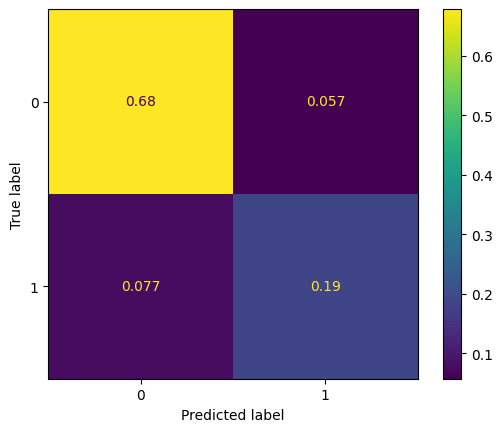

In [3]:
# Calculate confusion matrix
cm = confusion_matrix(data.testing.encode_labels(), predictions)
print('\nConfusion matrix:')
print(cm)

# Normalize confusion matrix
print(f'\nNormalized confusion matrix:')
normalized_cm = cm / sum(sum(cm))
print(normalized_cm)
print()

# Plot the confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(model, data.testing.features, data.testing.encode_labels(), normalize = 'all')

## Save the model

In [4]:
output_file = config.XGB_CLASSIFIER

with open(output_file, 'wb') as file:
    dump(model, file, protocol = 5)